In [1]:
import pymc3 as pm
from pymc3 import model_to_graphviz, Continuous, Discrete
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import seaborn as sns
import arviz as az

In [4]:
import networkx

In [5]:
from sklearn import preprocessing

In [6]:
from pymc3.theanof import floatX
import theano.tensor as tt

In [26]:
import theano.tensor as tt
import sklearn.gaussian_process

In [8]:
seed = 42
np.random.seed(seed)

In [9]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [10]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [11]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [12]:
sgrna_ids = np.repeat(["S" + str(i) for i in range(len(genes) * len(conditions) * len(sgrnas))], 2)
condition_ids = np.repeat(["C" + str(i) for i in range(len(genes) * len(conditions))], 4)
count_table.sgrnas = sgrna_ids
count_table.conditions = condition_ids

In [13]:
count_table

,genes,conditions,sgrnas,replicates
0,G0,C0,S0,R0
1,G0,C0,S0,R1
2,G0,C0,S1,R0
3,G0,C0,S1,R1
4,G0,C1,S2,R0
5,G0,C1,S2,R1
6,G0,C1,S3,R0
7,G0,C1,S3,R1
8,G1,C2,S4,R0
9,G1,C2,S4,R1


In [14]:
tau_true = sp.stats.halfcauchy.rvs(0, .1, size=1)
tau_true

array([0.06671342])

In [15]:
gamma_true = sp.array([.6, 6])
gamma_true

array([0.6, 6. ])

In [16]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([0.52582267, 0.62127506, 6.0186158 , 6.06741494])

In [17]:
l_true = sp.stats.norm.rvs(0, .1, size= len(conditions) * len(genes) * len(sgrnas))
l_true

array([-0.05808781, -0.05251698, -0.05713802, -0.09240828, -0.2612549 ,
        0.09503697,  0.08164451, -0.1523876 ])

In [18]:
l_idx = np.repeat(range(len(l_true)), len(replicates))
l_idx

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [19]:
beta_idx = np.repeat(range(len(beta_true)),
                     len(sgrnas) * len(replicates))
beta_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [29]:
k = sklearn.gaussian_process.kernels.Matern()

In [35]:
K = k(beta_true[beta_idx].reshape((16, 1)) + l_true[l_idx].reshape((16, 1)))

In [39]:
f = sp.stats.multivariate_normal.rvs(np.repeat(1, 16), K)
f

array([ 0.19714922,  0.19714921,  0.18536754,  0.18536754, -0.03760361,
       -0.03760361,  0.04798266,  0.04798266,  0.87390314,  0.87390314,
        1.09219552,  1.09219552,  1.15959613,  1.15959613,  0.8842148 ,
        0.8842148 ])

In [40]:
counts = sp.stats.norm.rvs(f, 0.25)
counts

array([ 0.13299168,  0.10519278,  0.50380094,  0.11237937, -0.70139762,
        0.04877588, -0.05089646, -0.02430156,  0.98713722,  0.83238791,
        1.14593023,  0.58661679,  0.92383193,  1.51058582,  0.8795771 ,
        0.46583864])

In [60]:
kern1d = np.exp((beta_true[beta_idx] - l_true[l_idx])**2)
kern2d = np.outer(kern1d, kern1d)
kern2d / kern2d.sum()

array([[1.20397412e-35, 1.20397412e-35, 1.19620393e-35, 1.19620393e-35,
        1.35651743e-35, 1.35651743e-35, 1.42478413e-35, 1.42478413e-35,
        1.14740842e-18, 1.14740842e-18, 1.48391844e-20, 1.48391844e-20,
        3.11225522e-20, 3.11225522e-20, 5.41546360e-19, 5.41546360e-19],
       [1.20397412e-35, 1.20397412e-35, 1.19620393e-35, 1.19620393e-35,
        1.35651743e-35, 1.35651743e-35, 1.42478413e-35, 1.42478413e-35,
        1.14740842e-18, 1.14740842e-18, 1.48391844e-20, 1.48391844e-20,
        3.11225522e-20, 3.11225522e-20, 5.41546360e-19, 5.41546360e-19],
       [1.19620393e-35, 1.19620393e-35, 1.18848389e-35, 1.18848389e-35,
        1.34776276e-35, 1.34776276e-35, 1.41558888e-35, 1.41558888e-35,
        1.14000329e-18, 1.14000329e-18, 1.47434155e-20, 1.47434155e-20,
        3.09216939e-20, 3.09216939e-20, 5.38051336e-19, 5.38051336e-19],
       [1.19620393e-35, 1.19620393e-35, 1.18848389e-35, 1.18848389e-35,
        1.34776276e-35, 1.34776276e-35, 1.41558888e-35, 1.415

In [21]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

## Model

In [52]:
count_table

,genes,conditions,sgrnas,replicates
0,0,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,1
4,0,1,2,0
5,0,1,2,1
6,0,1,3,0
7,0,1,3,1
8,1,2,4,0
9,1,2,4,1


In [23]:
l_true[l_idx]

array([-0.05808781, -0.05808781, -0.05251698, -0.05251698, -0.05713802,
       -0.05713802, -0.09240828, -0.09240828, -0.2612549 , -0.2612549 ,
        0.09503697,  0.09503697,  0.08164451,  0.08164451, -0.1523876 ,
       -0.1523876 ])

In [24]:
l_idx

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [51]:
with pm.Model() as model:
    tau_g = pm.InverseGamma('tau_g', 10., 1., shape=1)
    gamma = pm.Normal('gamma', 0., tau_g, shape=2)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta = pm.Normal('beta', gamma[[0, 0, 1, 1]], tau_b, shape=4)    
    l = pm.Lognormal('l', 0, .25, shape=8)
    
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)
    gp = pm.gp.Latent(cov_func=cov_func)
    K = pm.Deterministic( 
        np.exp(np.sum((beta[beta_idx] - l_true[l_idx])**2)))
    )
    f = sp.stats.multivariate_normal.rvs(np.repeat(1, 16), K)
    
    x = pm.Normal('x', mu = f, observed=counts)

testing here
testing here
testing here
testing here
testing here
testing here
testing here
testing here
testing here
testing here
testing here


ValueError: setting an array element with a sequence.

In [58]:
with model:
    t = pm.sample(10, ntune=10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_]
100%|██████████| 510/510 [00:00<00:00, 685.12it/s]
/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/pymc3/sampling.py:466: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [55]:
X.shape

(100, 1)

In [5]:
data = pd.read_csv("../data_raw/gene_summary.tsv", sep="\t")

In [13]:
G = networkx.read_edgelist(
    "../data_raw/mouse_gene_network.tsv",
    delimiter="\t", data=(('weight',float),), nodetype=str)

In [24]:
filter_genes = list(data.id.values[:4]) + \
            ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"]

In [25]:
networkx.nei

In [26]:
filter_data

,id,num,neg|score,neg|p-value,neg|fdr,neg|rank,neg|goodsgrna,neg|lfc,pos|score,pos|p-value,pos|fdr,pos|rank,pos|goodsgrna,pos|lfc
0,PSMC5,10,7.342000e-13,0.000005,0.000114,1,9,-0.098003,0.999990,0.999990,0.999995,90,0,-0.098003
1,PSMB1,10,3.090900e-12,0.000005,0.000114,2,9,-0.116810,1.000000,1.000000,0.999995,91,0,-0.116810
2,PSMC3,10,9.788600e-10,0.000005,0.000114,3,9,-0.052708,0.999560,0.999430,0.999995,89,0,-0.052708
3,POLR3K,10,2.574700e-07,0.000005,0.000114,4,8,-0.048451,0.970720,0.970730,0.999995,85,0,-0.048451
4,PSMC1,10,1.674400e-05,0.000115,0.002091,5,7,-0.041440,0.951490,0.951780,0.999995,81,0,-0.041440
13,PSMD4,10,1.420900e-01,0.290850,0.995418,14,3,-0.001814,0.341440,0.497830,0.999995,44,1,-0.001814
16,TH,10,1.745800e-01,0.333640,0.995418,17,3,-0.001190,0.413870,0.560790,0.999995,49,1,-0.001190
28,POLR2C,10,3.483400e-01,0.520110,0.995418,29,1,0.002940,0.114530,0.242440,0.885564,22,3,0.002940
35,POLR1B,10,4.104200e-01,0.569030,0.995418,36,2,-0.000904,0.010147,0.037418,0.555505,6,3,-0.000904


In [27]:
G = G.subgraph(np.sort(filter_genes))
adj = networkx.to_numpy_matrix(G, nodelist=np.sort(G.nodes()), weight='weight')

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


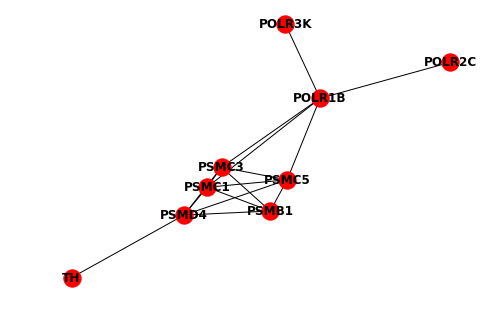

In [28]:
nodes = np.sort(G.nodes());
g = networkx.from_numpy_array(adj);
networkx.draw(g, font_weight='bold', labels={n: nodes[n] for n in g.nodes()});

In [62]:
adj

array([[0.        , 2.64913642, 1.70678613, 0.        , 0.79336804,
        1.10690699, 1.16002386, 0.        , 0.        ],
       [2.64913642, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [1.70678613, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 3.97387421,
        3.90412409, 3.93096682, 3.9720452 , 0.        ],
       [0.79336804, 0.        , 0.        , 3.97387421, 0.        ,
        4.31363258, 4.25705482, 4.32526574, 0.        ],
       [1.10690699, 0.        , 0.        , 3.90412409, 4.31363258,
        0.        , 4.22677194, 4.22326907, 0.        ],
       [1.16002386, 0.        , 0.        , 3.93096682, 4.25705482,
        4.22677194, 0.        , 4.19165085, 0.        ],
       [0.        , 0.        , 0.        , 3.9720452 , 4.32526574,
        4.22326907, 4.19165085, 0.        , 1.89745033],


In [105]:
def _markov_blank(adj, i):
    children = np.where(adj[i,:] != 0)[0]    
    parents = np.where(adj[:, i] != 0) [0]         
    return np.unique(np.append(children, parents))

array([1, 2, 4, 5, 6])

In [54]:
adj = np.asarray(adj)

In [70]:
mb = _markov_blank(adj, 0)
mb

[1 2 4 5 6]
[1 2 4 5 6]


array([1, 2, 4, 5, 6])

In [72]:
import scipy.stats

In [78]:
labels = scipy.stats.binom.rvs(1, .5, size=9)

In [82]:
(labels[mb] == labels[0])

array([False, False,  True,  True, False])

In [83]:
adj[mb, 0]

array([2.64913642, 1.70678613, 0.79336804, 1.10690699, 1.16002386])

In [81]:
(labels[mb] == labels[0]) *  adj[mb, 0]

array([0.        , 0.        , 0.79336804, 1.10690699, 0.        ])

In [79]:
np.sum((labels[mb] == labels[0]) * adj[mb, 0]) 

1.900275024345316

In [106]:
 def edge_potential(labels, x, adj_mb):
    s1 = np.sum((labels == x) * adj_mb)
    s2 = np.sum((labels != x) * adj_mb)
    return s1 - s2

In [131]:
lab

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [140]:
idx = 8
mb = _markov_blank(adj, 1)
edge_potential(lab[mb], 1, adj[mb, 1])

2.64913642034503

In [146]:
def _energy(labels):
    eneg = 0    
    for idx, l in enumerate(labels):        
        mb = _markov_blank(adj, idx)        
        eneg += edge_potential(labels[mb], labels[idx], adj[mb, idx])
    return eneg

In [175]:
lab = scipy.stats.binom.rvs(1, .5, size=9)
print(lab)
_energy(lab)

[1 0 1 0 1 0 0 1 0]


-25.715523099974252

In [178]:
binom = scipy.stats.binom.rvs

In [194]:
binom(1, .5)

1

In [92]:
with pm.Model() as model:
    A = BinaryMRF('A', G)
    B = pm.Normal('B', mu=20+A, sd=10)

AttributeError: 'BinaryMRF' object has no attribute 'logp'

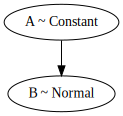

In [44]:
model_to_graphviz(model, )

In [46]:
with model:
    pm.sample(1000, ninit=1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [A]
>NUTS: [B]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:00<00:00, 3084.93draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


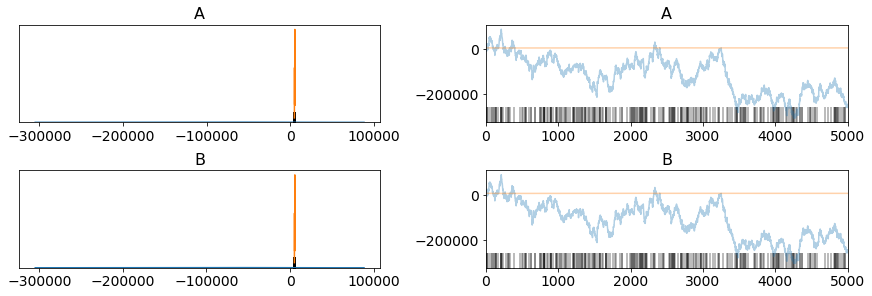

In [47]:
az.plot_trace(trace);

In [93]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def make_likelihood(true_variances):
    return tfd.MultivariateNormalDiag(
        scale_diag=tf.sqrt(true_variances))

dims = 10
dtype = np.float32
true_variances = tf.linspace(dtype(1), dtype(3), dims)
likelihood = make_likelihood(true_variances)

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 1.13.1; Detected an installation of version 1.10.0. Please upgrade TensorFlow to proceed.

In [ ]:

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=tf.zeros(dims),
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=likelihood.log_prob,
      step_size=0.5,
      num_leapfrog_steps=2),
    num_burnin_steps=500)

# Compute sample stats.
sample_mean = tf.reduce_mean(states, axis=0)
sample_var = tf.reduce_mean(
    tf.squared_difference(states, sample_mean),
    axis=0)
